# Setting up

In [ ]:
!gdown --id 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id 1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
!unzip wassa_dataset.zip
!rm wassa_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
To: /content/wassa_dataset.zip
100% 364k/364k [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
To: /content/emoticons.csv
100% 6.02k/6.02k [00:00<00:00, 13.2MB/s]
Archive:  wassa_dataset.zip
  inflating: wassa_train.csv         
  inflating: wassa_test.csv          
  inflating: wassa_val.csv           


In [ ]:
!pip install demoji
!pip install unidecode
!pip install snowballstemmer

     |████████████████████████████████| 245kB 4.0MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import demoji
import re
import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
demoji.download_codes()

... OK (Got response in 0.52 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


# Loading the dataset

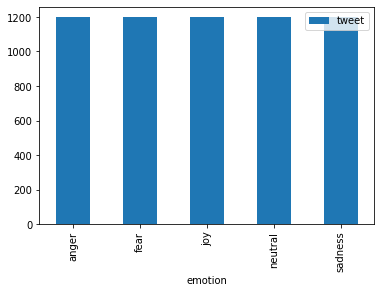

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [ ]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")
n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

In [ ]:
labels = list(set(df_train["emotion"].tolist()))
labels

['joy', 'neutral', 'anger', 'fear', 'sadness']

# Useful functions

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [ ]:
def preprocess_text(text, emodict, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # replace emojis with text
    dict = demoji.findall(result)

    for x in dict:
        result = result.replace(x, dict[x] + " ")

    for x in emodict:
        result = result.replace(x, emodict[x] + " ")
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("romanian")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [ ]:
def get_emoji_translation(file):
    df = pd.read_csv(file)
    dict = {}
    emojis = list(df["emoji"])
    words = list(df["word"])
    for i in range(len(words)):
        dict[emojis[i]] = words[i]

    return dict

In [ ]:
def preprocess_text_list(text_list, emodict, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i], emodict, stop_words)

In [ ]:
def preprocess_text_list_ro(text_list, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text_ro(text_list[i], stop_words)

In [ ]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

In [ ]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


# Preprocessing

In [ ]:
train_texts = df_train["tweet"].tolist()
val_texts = df_val["tweet"].tolist()
test_texts = df_test["tweet"].tolist()


train_labels = df_train["emotion"].tolist()
val_labels = df_val["emotion"].tolist()
test_labels = df_test["emotion"].tolist()

train_texts[:10]

['Kinda wished I watched mischievous kiss before playful kiss',
 'When you forget to mention you were bought dreamboys tickets 🙄😂',
 '@FreyaLynn @donniewahlberg yep! jimmy buffett FTW!!!... jimmy needs to tweet his words of wisdom every morning',
 "@philcampbell blue skies? where, it's still grey and hazy out of my window",
 'Some moving clips on youtube tonight of the vigil held at Tulsa Metropolitan Baptist church for #TerenceCruther #justice  #sadness',
 'Do what makes you successful and #happy now and forever',
 '@curligirl morning hon. what you having for breakfast? I cant decide',
 'Standard Candice starting the show with a pout #startasyoumeantogoon #GBBO',
 "[ @HedgehogDylan ] *she would frown a bit, folding her arms* 'why is it that every time I'm in need of assistance someone expects a lil **",
 'Someone make me a cofffeeeeeee......']

## English

In [ ]:
emodict = get_emoji_translation("emoticons.csv")  # loads emoticons dict
stop_words = stopwords.words("english")  # loads english stopwords

preprocess_text_list(train_texts, emodict, stop_words)
preprocess_text_list(val_texts, emodict, stop_words)
preprocess_text_list(test_texts, emodict, stop_words)

train_texts[:10]

['kind wished watched mischievous kiss playf kiss ',
 'forget mention bought dreamboys tickets fac rolling eyes fac tears joy ',
 'yep  jimmy buffett ftw     jimmy needs tweet words wisdom every morning ',
 'blu skies   s still grey hazy window ',
 'moving clips youtub tonight vigil held tuls metropolitan baptist church  terencecruther  justic  sadness ',
 'makes successf  happy forever ',
 'morning hon  breakfast  cant decid ',
 'standard candic starting show pout  startasyoumeantogoon  gbbo ',
 '  she would frown bit  folding arms why every tim m need assistanc someon echeeky ects lil  ',
 'someon mak cofffeeeeee   ']

# Encoding

In [ ]:
 # Vectorizing texts
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [ ]:
# label encoding
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# SVM

## Defying the model

In [ ]:
svm_model = svm.SVC(probability=True)
svm_model.fit(vectorized_train_texts, encoded_train_labels)

In [ ]:
train_predicitons = svm_model.predict(vectorized_train_texts)
acc_train  = accuracy_score(encoded_train_labels, train_predicitons)
acc_train

0.997

## Validation

In [ ]:
y_pred = svm_model.predict_log_proba(vectorized_val_texts)
y_pred

In [ ]:
acc = accuracy_score(encoded_val_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
recall = recall_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
f1 = f1_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.8733333333333333
, precision = 0.8733333333333333
, recall = 0.8733333333333333
, f1_score = 0.8733333333333333



## Testing

In [ ]:
y_pred = svm_model.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_test_labels, y_pred)


Model has acc = 0.8533333333333334
, precision = 0.8618798525943022
, recall = 0.8533333333333333
, f1_score = 0.8557682334007488



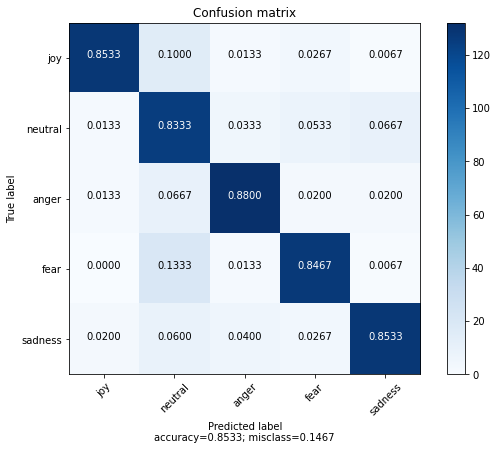

In [ ]:
y_pred = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(test_labels, y_pred, labels)
plot_confusion_matrix(cm, labels)

# Building SVM class

In [ ]:
class SVM_model:
  def __init__(self, classifier, encoder, emodict, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._emodict = emodict
    self._stop_words = stop_words
    self._vectorizer = vectorizer
  
  def _preprocess_text(self, text, emodict, stop_words):
    # make lowercase and strip empty spaces
      result = text.lower()
      # replace emojis with text
      dict = demoji.findall(result)

      for x in dict:
          result = result.replace(x, dict[x] + " ")

      for x in emodict:
          result = result.replace(x, emodict[x] + " ")
      # strip extra spaces
      result = result.strip()
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", result)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      # strip diacritics
      result = unidecode.unidecode(result)
      # english stopwords
      word_list = word_tokenize(result)
      # english stemmer
      ps = SnowballStemmer("romanian")

      stemmed_sentence = ""
      for word in word_list:
          if word not in stop_words:
              stemmed_sentence += ps.stem(word)
              stemmed_sentence += " "

      result = stemmed_sentence
      whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
      result = ''.join(filter(whitelist.__contains__, result))
      result = ''.join([i for i in result if not i.isdigit()])
      return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._emodict, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [ ]:
svm_cls = SVM_model(svm_model, label_encoder, emodict, stop_words, vectorizer)

In [ ]:
predictions = svm_cls.detect_emotions_with_labels(val_texts)
acc = accuracy_score(val_labels, predictions)
acc

0.8706666666666667

## Testing


In [ ]:
preds = svm_cls.detect_emotions_with_labels(test_texts)

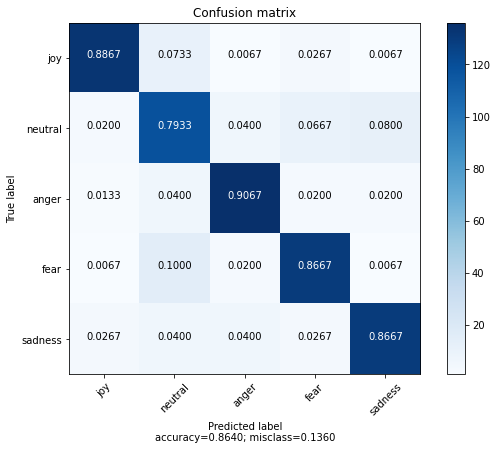

In [ ]:
cm = confusion_matrix(test_labels, preds, labels)
plot_confusion_matrix(cm, labels)

## Saving the model

In [ ]:
pickle_object(svm_cls, "svm_model.obj")

In [ ]:
svm_cls = pickle_load_object("svm_model.obj")

In [ ]:
preds = svm_cls.detect_emotions_with_labels(test_texts)

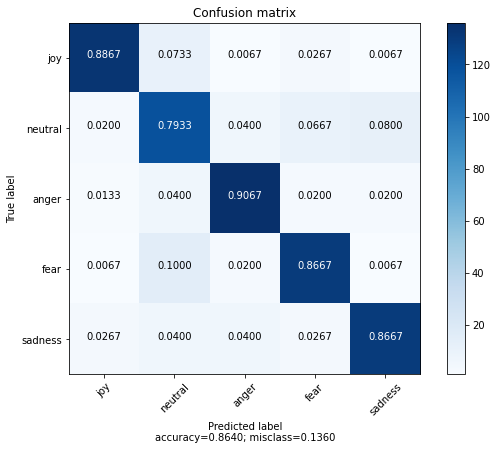

In [ ]:
cm = confusion_matrix(test_labels, preds, labels)
plot_confusion_matrix(cm, labels)

# Multinomial Naive bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(vectorized_train_texts, encoded_train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
preds = mnb.predict(vectorized_val_texts)
preds

array([4, 1, 1, 4, 0, 2, 0, 0, 0, 2, 1, 3, 1, 3, 0, 2, 2, 3, 4, 2, 1, 0,
       0, 1, 0, 4, 0, 0, 0, 1, 3, 1, 1, 4, 1, 0, 4, 0, 2, 0, 4, 2, 0, 0,
       2, 4, 2, 1, 2, 1, 0, 0, 2, 3, 4, 4, 4, 4, 3, 2, 0, 0, 2, 4, 3, 2,
       3, 4, 2, 1, 0, 2, 4, 4, 4, 4, 3, 1, 2, 2, 0, 2, 4, 4, 1, 1, 4, 0,
       2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 3, 4, 4, 2, 3, 3, 0, 2, 3, 4,
       1, 3, 1, 0, 2, 2, 0, 1, 4, 4, 4, 0, 0, 2, 4, 3, 0, 4, 0, 0, 4, 1,
       4, 2, 1, 2, 3, 0, 2, 4, 1, 3, 1, 1, 4, 2, 0, 1, 1, 2, 4, 4, 2, 4,
       3, 3, 1, 1, 1, 1, 0, 1, 3, 2, 4, 1, 4, 4, 4, 4, 3, 1, 4, 2, 2, 0,
       3, 2, 2, 0, 4, 4, 1, 1, 4, 1, 1, 2, 0, 2, 1, 3, 0, 4, 0, 1, 2, 3,
       0, 0, 1, 4, 2, 2, 0, 4, 4, 4, 0, 0, 4, 3, 4, 4, 0, 4, 3, 3, 2, 4,
       0, 4, 1, 0, 4, 4, 2, 0, 4, 2, 1, 4, 4, 0, 3, 1, 4, 2, 2, 0, 3, 4,
       4, 4, 1, 4, 1, 1, 2, 0, 2, 0, 4, 2, 1, 0, 0, 2, 0, 0, 3, 3, 4, 0,
       4, 4, 2, 1, 4, 0, 1, 2, 4, 1, 4, 4, 4, 4, 1, 0, 0, 2, 1, 4, 1, 4,
       0, 4, 4, 1, 0, 3, 2, 0, 2, 2, 2, 3, 0, 3, 0,

In [ ]:
preds_test = mnb.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_val_labels, preds)

Model has acc = 0.8213333333333334
, precision = 0.8207896296291688
, recall = 0.8213333333333332
, f1_score = 0.8172448944929753



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.8026666666666666
, precision = 0.8014707230572864
, recall = 0.8026666666666668
, f1_score = 0.8006028750562351



# Gaussian Naive Bayes

In [ ]:
gaussian_nb = GaussianNB()


In [ ]:
x = vectorized_train_texts.toarray()

In [ ]:
gaussian_nb.fit(x, encoded_train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = gaussian_nb.predict(vectorized_val_texts.toarray())

In [ ]:
compute_metrics(encoded_val_labels, preds)

Model has acc = 0.5853333333333334
, precision = 0.5841413818745321
, recall = 0.5853333333333334
, f1_score = 0.5836231832185252

